In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import csv
from PIL import Image

In [31]:
pip install librosa

Note: you may need to restart the kernel to use updated packages.


In [32]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [33]:
!pwd

/root/3A/ProjetLong/OrthopteraStridulationClassifier/Notebooks/XgBoost


In [34]:
# Path Yolo results
path_audible_results_YOLO = "../../../DataSet/soundscape_to_5s/Selection soundscapes 1 min split 5s/"
path_audible_csv_YOLO = "../../../DataSet/soundscape_to_5s/CSV soundscapes 1 min split 5s boxes/1min_to_5s_boxes.csv"
df_yolo = pd.read_csv(path_audible_csv_YOLO)

# path for audio files 
path_audible_audio_files = "../../../DataSet/NewDataSet5sec/Selection soundscapes 1 min/"
path_audible_csv = "../../../DataSet/NewDataSet5sec/selected_soundscapes.csv" 
df = pd.read_csv(path_audible_csv)

In [35]:
# spectrogrammes pour chaque audio
# Charger l'audio
filtered_audio = set()
with open(path_audible_csv, newline='') as fichier_csv:
    lecteur_csv = csv.reader(fichier_csv)
    next(lecteur_csv)
    # Parcourir chaque ligne du fichier CSV
    for ligne in lecteur_csv:
        filtered_audio.add(ligne[1])

audio_list = list(filtered_audio)


In [36]:
colonnes = ["unique_code", "max_frequency", "min_frequency","img_width", "img_height", "x1", "x2", "y1", "y2", "duree", "start_split", "end_split", "predicted_label"]
new_df = pd.DataFrame(columns=colonnes)
new_df["unique_code"] = df_yolo["unique_code"]
new_df["start_split"] = df_yolo["start_split"]
new_df["end_split"] = df_yolo["end_split"]
new_df["x1"] = df_yolo["x1"]
new_df["x2"] = df_yolo["x2"]
new_df["y1"] = df_yolo["y1"]
new_df["y2"] = df_yolo["y2"]
new_df["img_width"] = df_yolo["img_width"]
new_df["img_height"] = df_yolo["img_height"]
#new_df = df_yolo

based_sr = 48000
for ind, row in new_df.iterrows():
    #print(row)
    # get y1 et y2 
    width = row["img_width"]
    height = row["img_height"]
    x1 = row["x1"]
    x2 = row["x2"]
    y1 = row["y1"]
    y2 = row["y2"]
    start = row["start_split"]
    end = row["end_split"]

    #debut = int((start + x1*5/width)*based_sr)
    #fin = int((start + x2*5/width)*based_sr)

    minfreq = (y1 * based_sr)/(2*height)
    maxfreq = (y2 * based_sr)/(2*height)
    #print(minfreq)
    #print(maxfreq)
    new_df.loc[ind, "min_frequency"] = minfreq
    new_df.loc[ind, "max_frequency"] = maxfreq
    new_df.loc[ind, "duree"] = end - start


In [37]:
print(new_df)

                              unique_code max_frequency min_frequency  \
0        Anura_estalep09FR_27III2022_1330   23601.95122  21752.195122   
1          Anura_pechpuy46FR_06V2022_1915  20417.560976  15313.170732   
2          Anura_pechpuy46FR_06V2022_1915  20394.146341       15360.0   
3          Anura_pechpuy46FR_06V2022_1915  20417.560976  15313.170732   
4          Anura_pechpuy46FR_06V2022_1915  20394.146341  15313.170732   
...                                   ...           ...           ...   
2324  Orthoptera_XXXXsma07FR_27IV2022_112  20815.609756   5830.243902   
2325  Orthoptera_XXXXsma07FR_27IV2022_112  20979.512195   5900.487805   
2326  Orthoptera_XXXXsma07FR_27IV2022_112  20956.097561        5760.0   
2327  Orthoptera_XXXXsma07FR_27IV2022_112  20909.268293   5853.658537   
2328  Orthoptera_XXXXsma07FR_27IV2022_112   20839.02439   5783.414634   

      img_width  img_height   x1   x2   y1    y2 duree  start_split  \
0           469        1025   44   93  929  1008    

In [38]:
# Préparation des données 
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

#path_global_5s_train = "../../../DataSet/CSVs_morceaux_audio_5s/Audible/train_audible_recording_chunks.csv"
path_global_5s_train = "../../../DataSet/NewDataSet5sec/train_audible_recording_chunks.csv"

df_train = pd.read_csv(path_global_5s_train)
df_train = df_train[df_train["label_class"] == "Insecta"]

label_encoder = LabelEncoder()
label_encoder.fit(df_train['label'])

y_label = label_encoder.transform(df_train['label'])

df_train['duree'] = df_train['duree_min'] * 60 + df_train['duree_sec']
df_train = df_train[['max_frequency', 'min_frequency', 'duree']]
df_train['min_frequency'] = df_train['min_frequency'].astype(int)
df_train['max_frequency'] = df_train['max_frequency'].astype(int)

# Gestion des valeurs manquantes
#df.fillna(df.mean(), inplace=True)
df_train = df_train.dropna()

# Gestion des variables catégorielles
df_train = pd.get_dummies(df_train)

X_train = df_train

#################### Préparer X_test avec les données ci-dessus 
#y_yolo_label = label_encoder.transform(new_df['label']) # A changer

new_dftest = new_df[['max_frequency', 'min_frequency', 'duree']]
new_dftest['min_frequency'] = new_dftest['min_frequency'].astype(int)
new_dftest['max_frequency'] = new_dftest['max_frequency'].astype(int)

# Gestion des valeurs manquantes
new_dftest.fillna(new_dftest.mean(), inplace=True)
new_dftest = new_dftest.dropna()

# Gestion des variables catégorielles
new_dftest = pd.get_dummies(new_dftest)

X_test = new_dftest

/tmp/ipykernel_13206/2787266268.py:11: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(path_global_5s_train)
/tmp/ipykernel_13206/2787266268.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_dftest['min_frequency'] = new_dftest['min_frequency'].astype(int)
/tmp/ipykernel_13206/2787266268.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_dftest['max_frequency'] = new_dftest['max_frequency'].astype(int)
/tmp/ipykernel_

In [39]:
print(X_test)

      max_frequency  min_frequency  duree
0             23601          21752      5
1             20417          15313      5
2             20394          15360      5
3             20417          15313      5
4             20394          15313      5
...             ...            ...    ...
2324          20815           5830      5
2325          20979           5900      5
2326          20956           5760      5
2327          20909           5853      5
2328          20839           5783      5

[2329 rows x 3 columns]


In [40]:
# XGBoost
# Initialiser et entraîner le modèle XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=2)

# Calculer les poids des classes
# 'balanced' ajuste automatiquement les poids inversément proportionnels aux fréquences des classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_label), y=y_label)

# Créer un dictionnaire des poids pour faciliter l'application des poids aux échantillons
weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Appliquer les poids aux instances de formation
sample_weight = np.array([weights_dict[y] for y in y_label])

# Entraînement du modèle avec les poids des instances
xgb_model.fit(X_train, y_label)

predictions_xgb = xgb_model.predict(X_test)

predictions_label_xgb = label_encoder.inverse_transform(predictions_xgb)

# Évaluation LightGBM
#print("Évaluation Yolo :")
#print("Accuracy sur l'ensemble de validation:", accuracy_score(y_yolo_label, predictions_label))
#print(classification_report(y_yolo_label, predictions_label))

# matrice de confusion
#cm = confusion_matrix(y_yolo_label, predictions_label)
#y_test_inversed = label_encoder.inverse_transform(y_yolo_label)

#unique_labels = np.unique(y_test_inversed)

# plt.figure(figsize=(30,30))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
# plt.title('Matrice de confusion - Labels')
# plt.ylabel('Valeur réelle')
# plt.xlabel('Valeur prédite')
# plt.show()

In [41]:
print(predictions_label_xgb)
#print(len(predictions_label_xgb))
#print(np.count_nonzero(predictions_label_xgb == 17))

['Phaneroptera nana' 'Phaneroptera nana' 'Phaneroptera nana' ...
 'Chorthippus brunneus' 'Decticus albifrons' 'Chorthippus brunneus']


In [42]:
# Random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")

rf_classifier.fit(X_train, y_label)

predictions_randomf = rf_classifier.predict(X_test)

predictions_label_randomf = label_encoder.inverse_transform(predictions_randomf)

# # Évaluation LightGBM
# print("Évaluation LightGBM :")
# print("Accuracy sur l'ensemble de validation:", accuracy_score(y_label, predictions_label))
# print(classification_report(y_label, predictions_label))

# # matrice de confusion
# cm = confusion_matrix(y_label, predictions_label)
# y_test_inversed = label_encoder.inverse_transform(y_label)

# unique_labels = np.unique(y_test_inversed)

# plt.figure(figsize=(30,30))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
# plt.title('Matrice de confusion - Labels')
# plt.ylabel('Valeur réelle')
# plt.xlabel('Valeur prédite')
# plt.show()

In [43]:
print(predictions_label_randomf)

['Phaneroptera nana' 'Phaneroptera nana' 'Phaneroptera nana' ...
 'Chorthippus jacobsi' 'Chorthippus jacobsi' 'Chorthippus jacobsi']


In [44]:
df_randomf = new_df
df_randomf['predicted_label'] = predictions_label_randomf

df_xgb= new_df
df_xgb['predicted_label'] = predictions_label_xgb

def acc(sub_df) : 
    val = 0 
    for _,row in sub_df.iterrows() : 
        pred = row['predicted_label']
        code = row['unique_code']
        inter_df = df[(df['code_unique'] == code) & (df['label_class'] == 'Insecta')]
        for _, row2 in inter_df.iterrows() : 
            truth = row2['label'] 
            if truth == pred : 
                val +=1 
                break
    result = val/len(sub_df['predicted_label'])
    print(len(new_df['predicted_label']))
    return result 

acc_xgb  = acc(df_xgb)
print(acc_xgb)
acc_randf = acc(df_randomf)
print(acc_randf)

2329
0.012881064834693002
2329
0.012881064834693002


In [45]:
!pwd

/root/3A/ProjetLong/OrthopteraStridulationClassifier/Notebooks/XgBoost


In [49]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

df_truth = pd.read_csv(path_audible_csv)
# TODO : génerer les spectrogrammes 
soundscape_image_path = "../../../DataSet/NewSpectro1min/"

def image_to_compare(code_unique, save_path, df_yolo) : 

    #df_yolo_filtered = df_yolo[df_yolo["unique_code"] == code_unique]
    df_truth_filtered = df_truth[(df_truth["code_unique"] == code_unique) & (df_truth["label_class"] == "Insecta")]

    chunk_duration = (df_truth_filtered["duree_min"] * 60 + df_truth_filtered["duree_sec"]).iloc[0]

    image = Image.open(f'{soundscape_image_path}{code_unique}.png')
    img_width, img_height = image.width, image.height

    # On fait le truth
    #image = Image.open(f'{soundscape_image_path}{code_unique}.png')
    #img_width, img_height = image.width, image.height

    #plt.figure(figsize=(50, 10))

    # for _, row in df_yolo_filtered.iterrows():
    #     label = row["predicted_label"]
    #     x1 = row["x1"]
    #     x2 = row["x2"]
    #     y1 = row["y1"]
    #     y2 = row["y2"]
    #     start_split = row["start_split"] * (img_width // chunk_duration)
    #     end_split = row["end_split"] * (img_width // chunk_duration)

    #     t1_pixel = x1 + start_split
    #     f1_pixel = y1
    #     f2_pixel = y2
    #     t2_pixel = x2 + start_split

    #     rect = patches.Rectangle((t1_pixel, f1_pixel), t2_pixel - t1_pixel, f2_pixel - f1_pixel, linewidth=2, edgecolor='yellow', facecolor='none')
    #     plt.gca().add_patch(rect)

        # plt.text(t1_pixel, f1_pixel + 0.01, label, verticalalignment='bottom', horizontalalignment='left',
        #     color='black',  # Couleur du texte
        #     bbox=dict(facecolor='yellow', edgecolor='none', pad=2.0))

    # plt.imshow(image)
    # plt.title(f'{code_unique} predicted')
    # plt.tight_layout()
    # plt.savefig(f'{save_path}/{code_unique}_predicted.png')
    # plt.close() 

    plt.figure(figsize=(50, 10))

    for _, row in df_truth_filtered.iterrows():
        chunk_initial_time = 0.0
        chunk_final_time = 60.0
        annotation_initial_time = row["annotation_initial_time"]
        annotation_final_time = row["annotation_final_time"]
        min_frequency = row["min_frequency"]
        max_frequency = row["max_frequency"]
        label = row["label"]

        # Create the BB
        t1 = row["annotation_initial_time"]
        t2 = row["annotation_final_time"]
        f1 = int(row['min_frequency'])
        f2 = int(row['max_frequency'])
        sr = 48000 #row['sampling_rate']
        #sr = row['sampling_rate']

        t1_pixel = int(t1 * img_width/chunk_duration)
        t2_pixel = int(t2 * img_width/chunk_duration)

        # for the frequency, the spectrogram is flipped
        f1_pixel = img_height - int(f1 * img_height/(sr/2))
        f2_pixel = img_height - int(f2 * img_height/(sr/2))

        rect = patches.Rectangle((t1_pixel, f1_pixel), t2_pixel - t1_pixel, f2_pixel - f1_pixel, linewidth=2, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)

        plt.text(t1_pixel, f2_pixel + 0.01, label, verticalalignment='bottom', horizontalalignment='left',
            color='white',  # Couleur du texte
            bbox=dict(facecolor='red', edgecolor='none', pad=2.0))

    plt.imshow(image)
    plt.title(f'{code_unique} truth')
    plt.tight_layout()
    plt.savefig(f'{save_path}/{code_unique}_truth.png')
    plt.clf()
    plt.cla()
    #plt.close
    
    print(f'{code_unique} fini')

  0%|          | 0/15 [00:00<?, ?it/s]

  7%|▋         | 1/15 [00:05<01:18,  5.62s/it]

Aves_184Barjac09FR_15VI2022_0000 fini


 13%|█▎        | 2/15 [00:09<01:01,  4.74s/it]

Orthoptera_pechpuy46FR_06V2022_2100 fini


 20%|██        | 3/15 [00:12<00:47,  3.93s/it]

Anura_lanibra11FR_14IV2022_2130 fini


 27%|██▋       | 4/15 [00:16<00:41,  3.78s/it]

Anura_pechpuy46FR_08V2022_2215 fini


 33%|███▎      | 5/15 [00:18<00:32,  3.23s/it]

Aves_140Cassag31FR_21V2021_0000 fini


 40%|████      | 6/15 [00:20<00:25,  2.88s/it]

Aves_34Eoux31FR_17VI2019_0000 fini


 47%|████▋     | 7/15 [00:24<00:24,  3.09s/it]

Anura_pechpuy46FR_07V2022_2230 fini


 53%|█████▎    | 8/15 [00:27<00:22,  3.15s/it]

Orthoptera_cdbomar12FR_28IV2022_2200 fini


 60%|██████    | 9/15 [00:31<00:19,  3.30s/it]

Anura_pechpuy46FR_10V2022_2145 fini


 67%|██████▋   | 10/15 [00:35<00:17,  3.60s/it]

Aves_131Eoux31FR_29V2020_0000 fini


 73%|███████▎  | 11/15 [00:37<00:12,  3.19s/it]

Aves_213Cassou09FR_07VII2022_1309 fini


 80%|████████  | 12/15 [00:41<00:09,  3.27s/it]

Aves_84Boussa31FR_18VI2019_1300 fini


 87%|████████▋ | 13/15 [00:44<00:06,  3.43s/it]

Aves_150Cassag31FR_29V2020_1300 fini


 93%|█████████▎| 14/15 [00:47<00:03,  3.06s/it]

Aves_35Eoux31FR_17VI2019_0700 fini


100%|██████████| 15/15 [00:50<00:00,  3.37s/it]

Anura_pechpuy46FR_06V2022_2115 fini


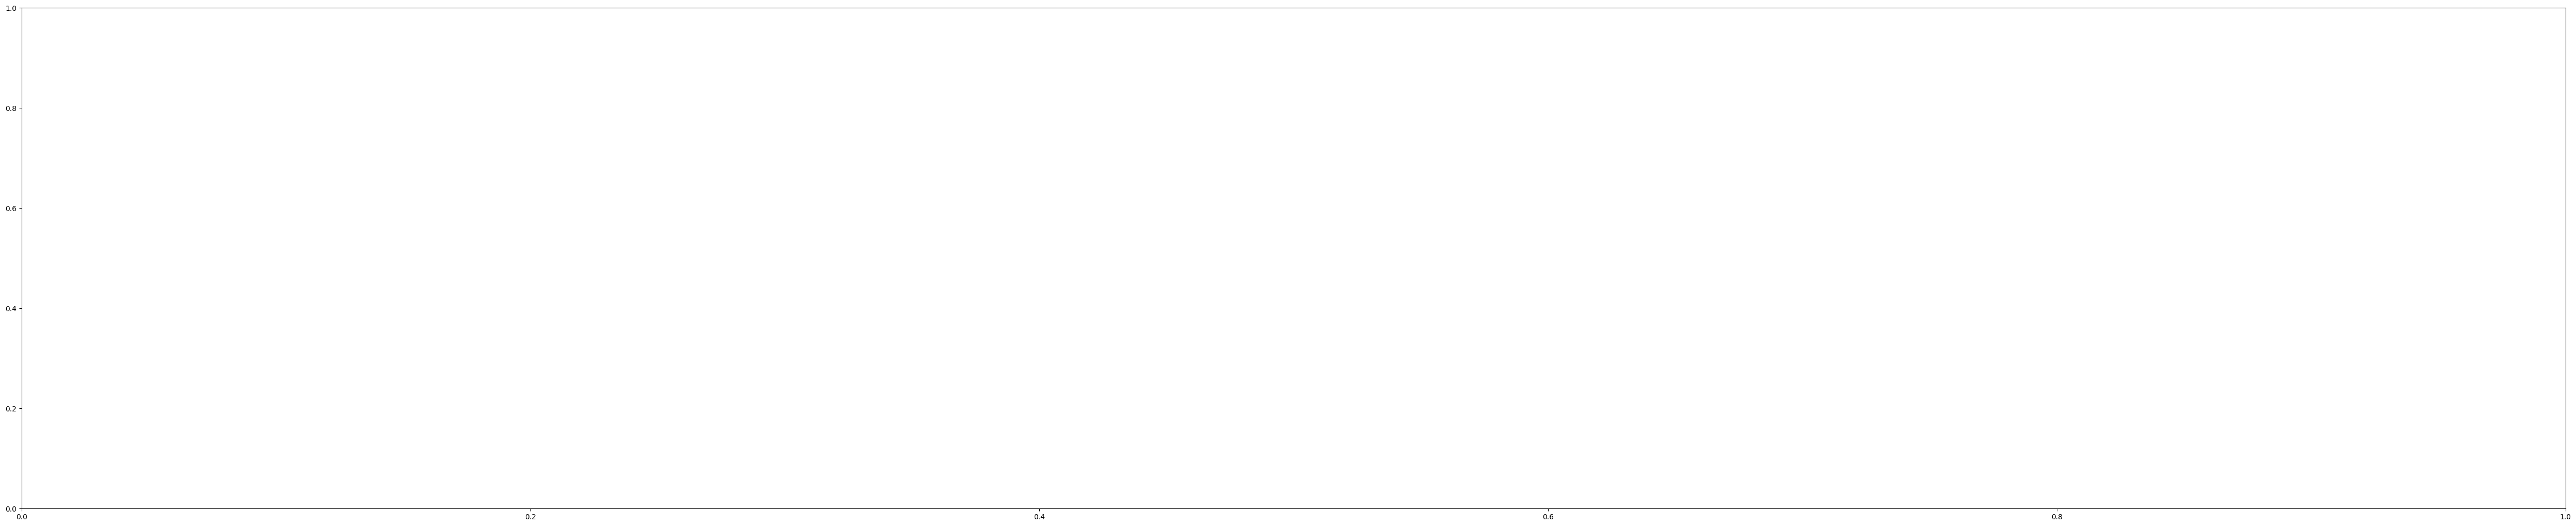

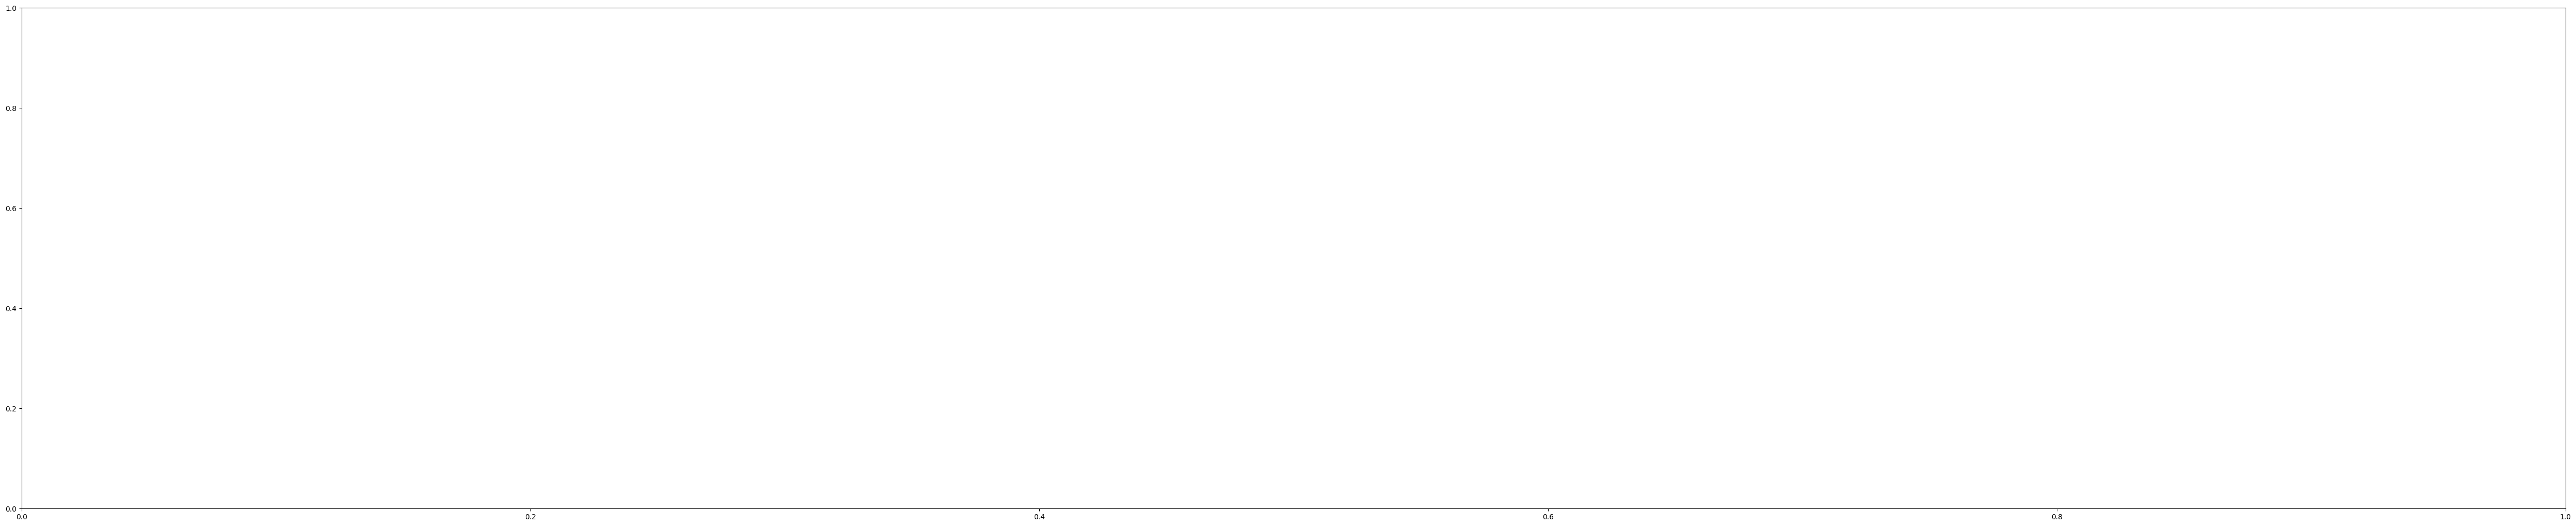

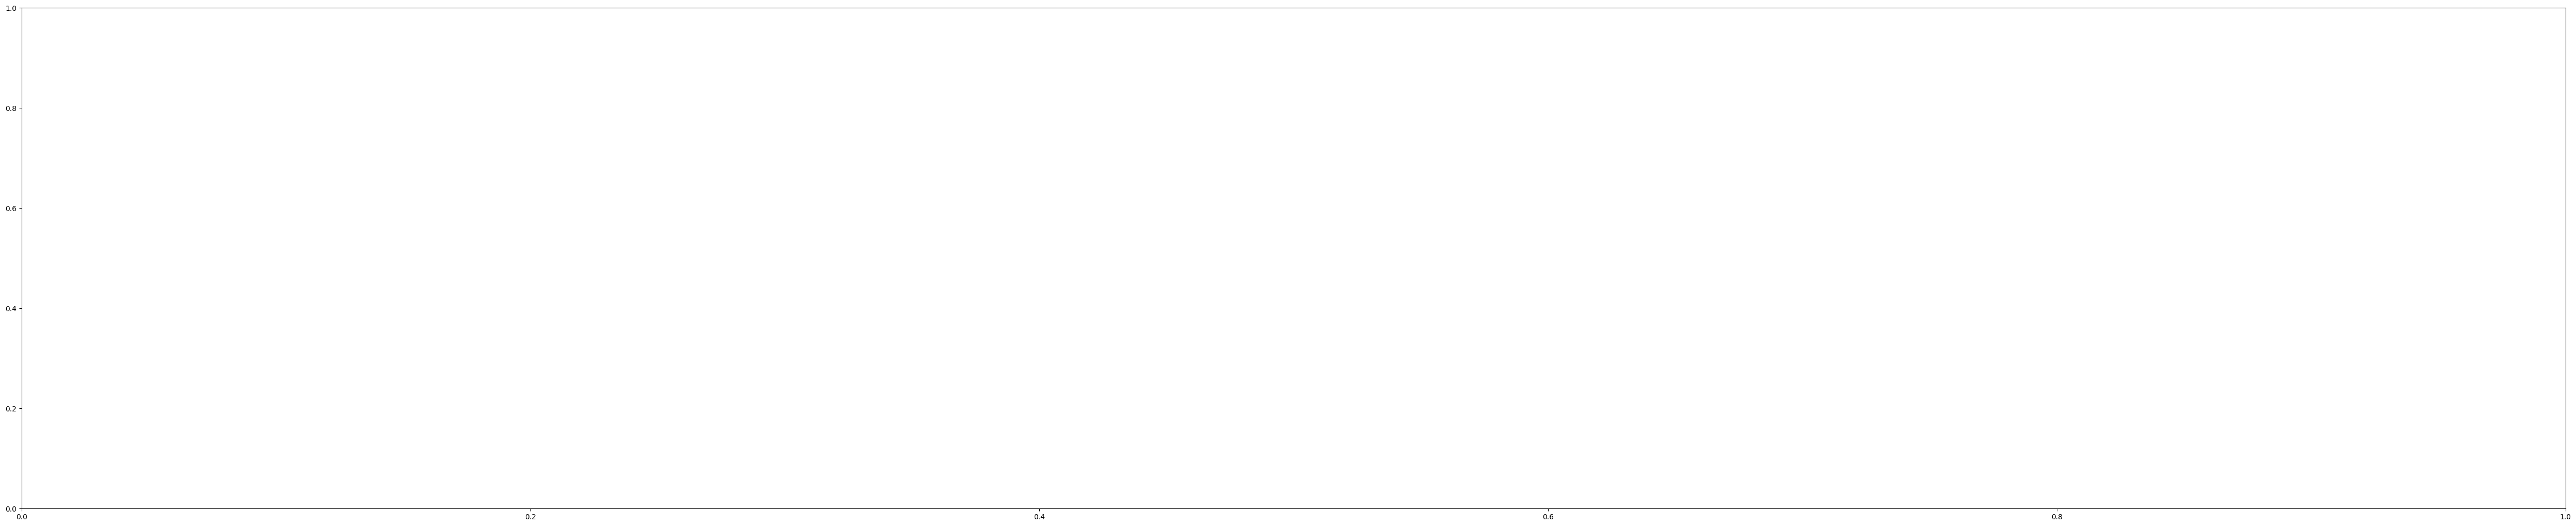

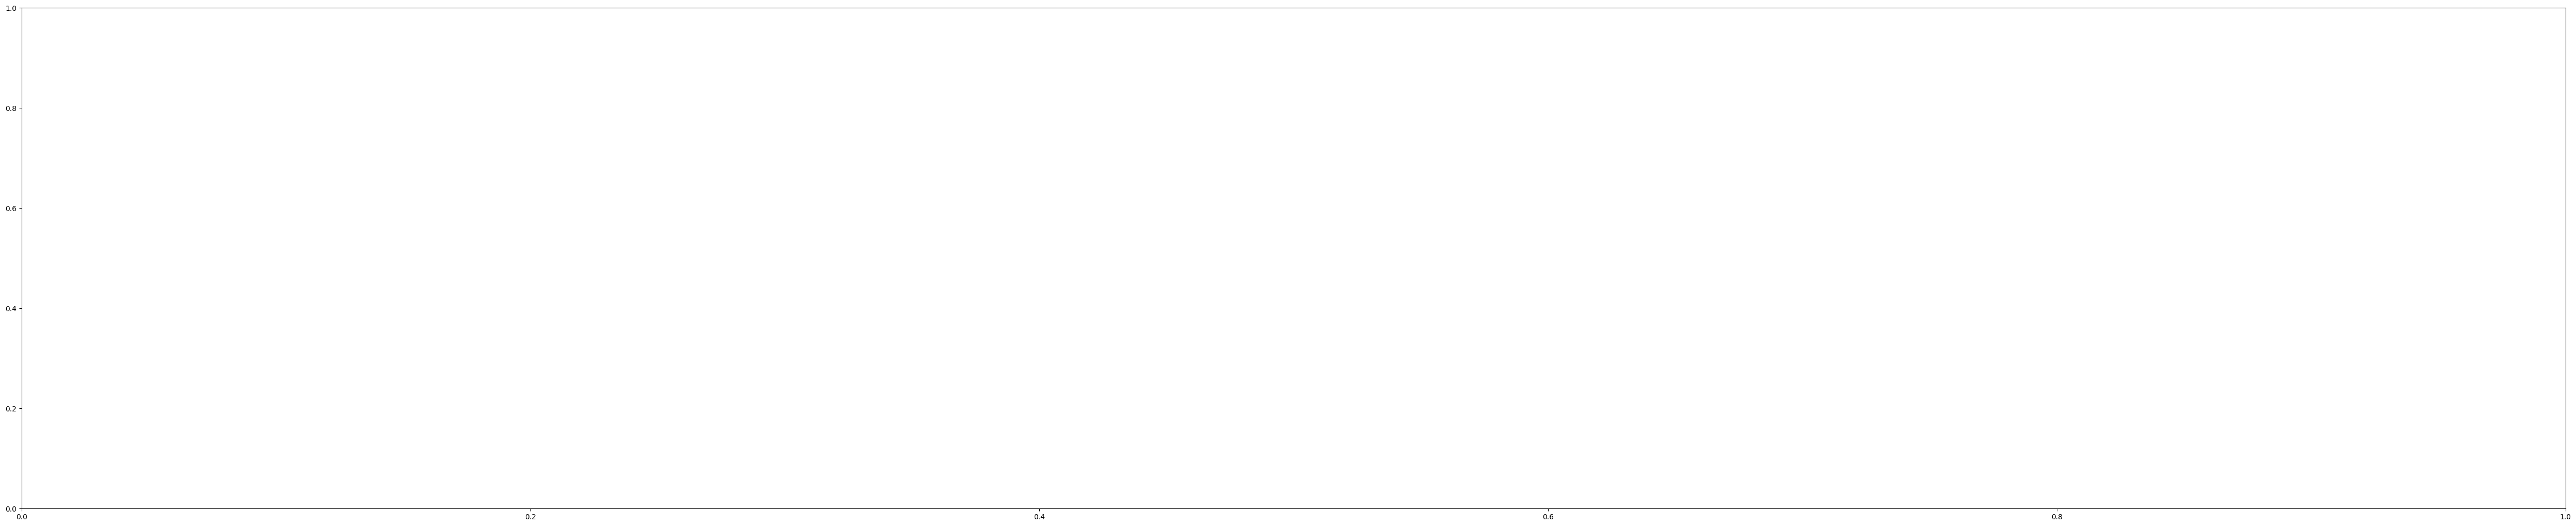

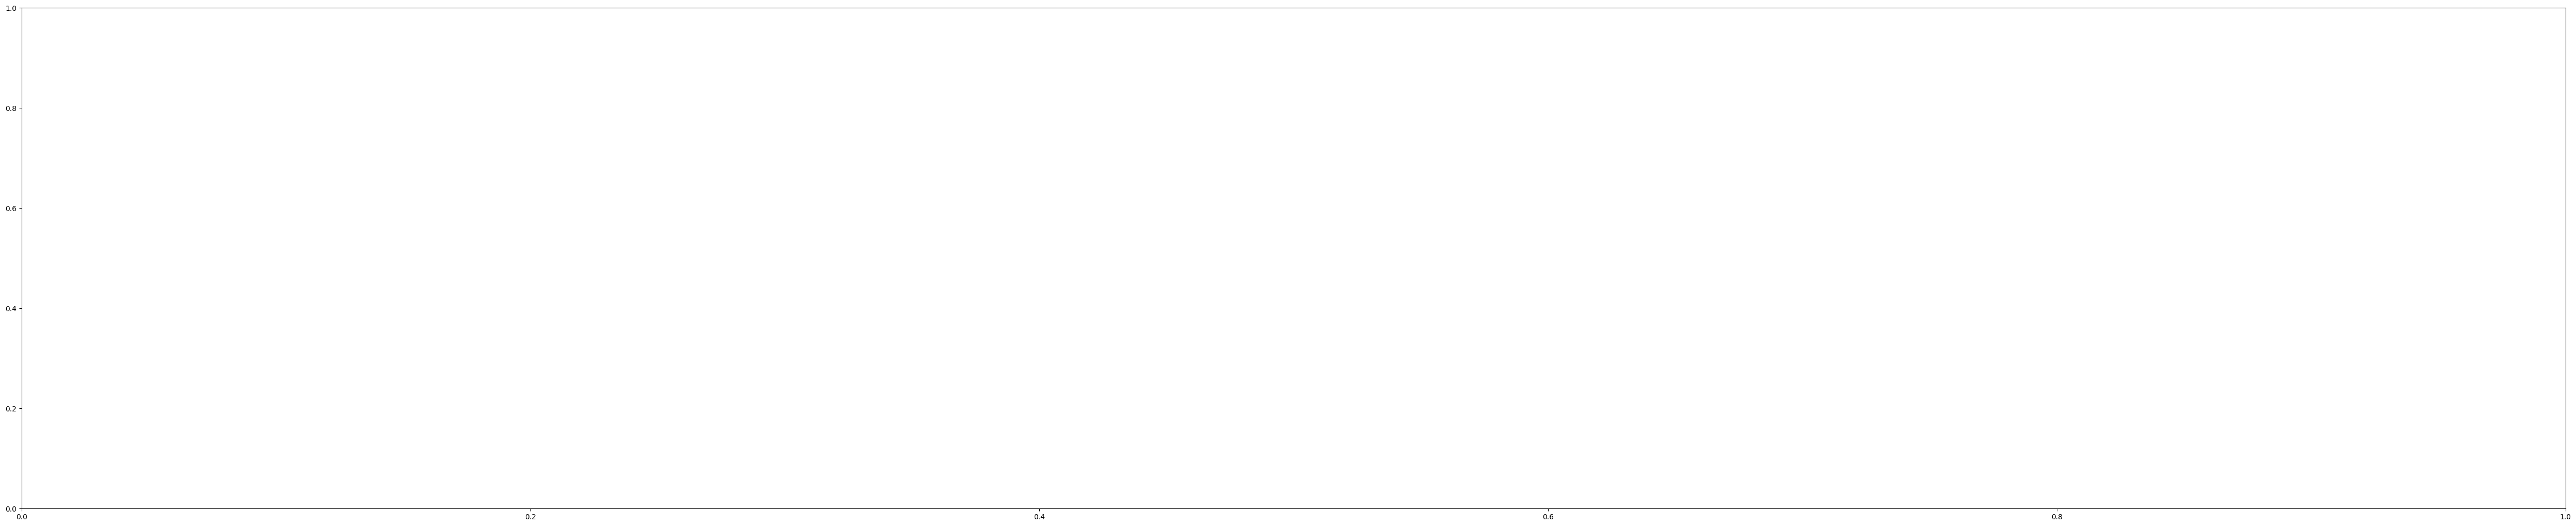

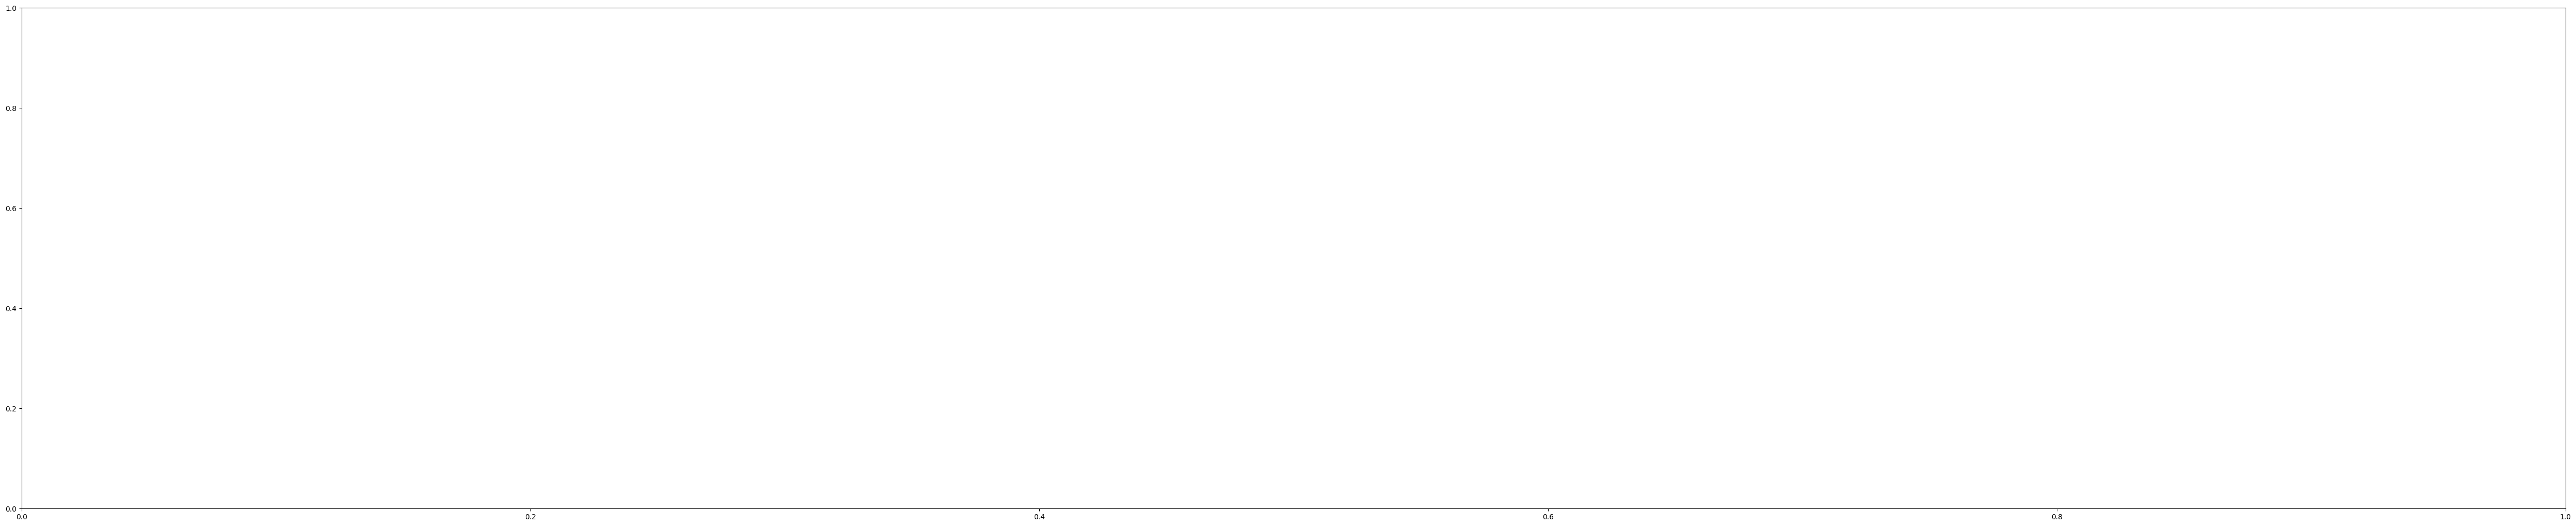

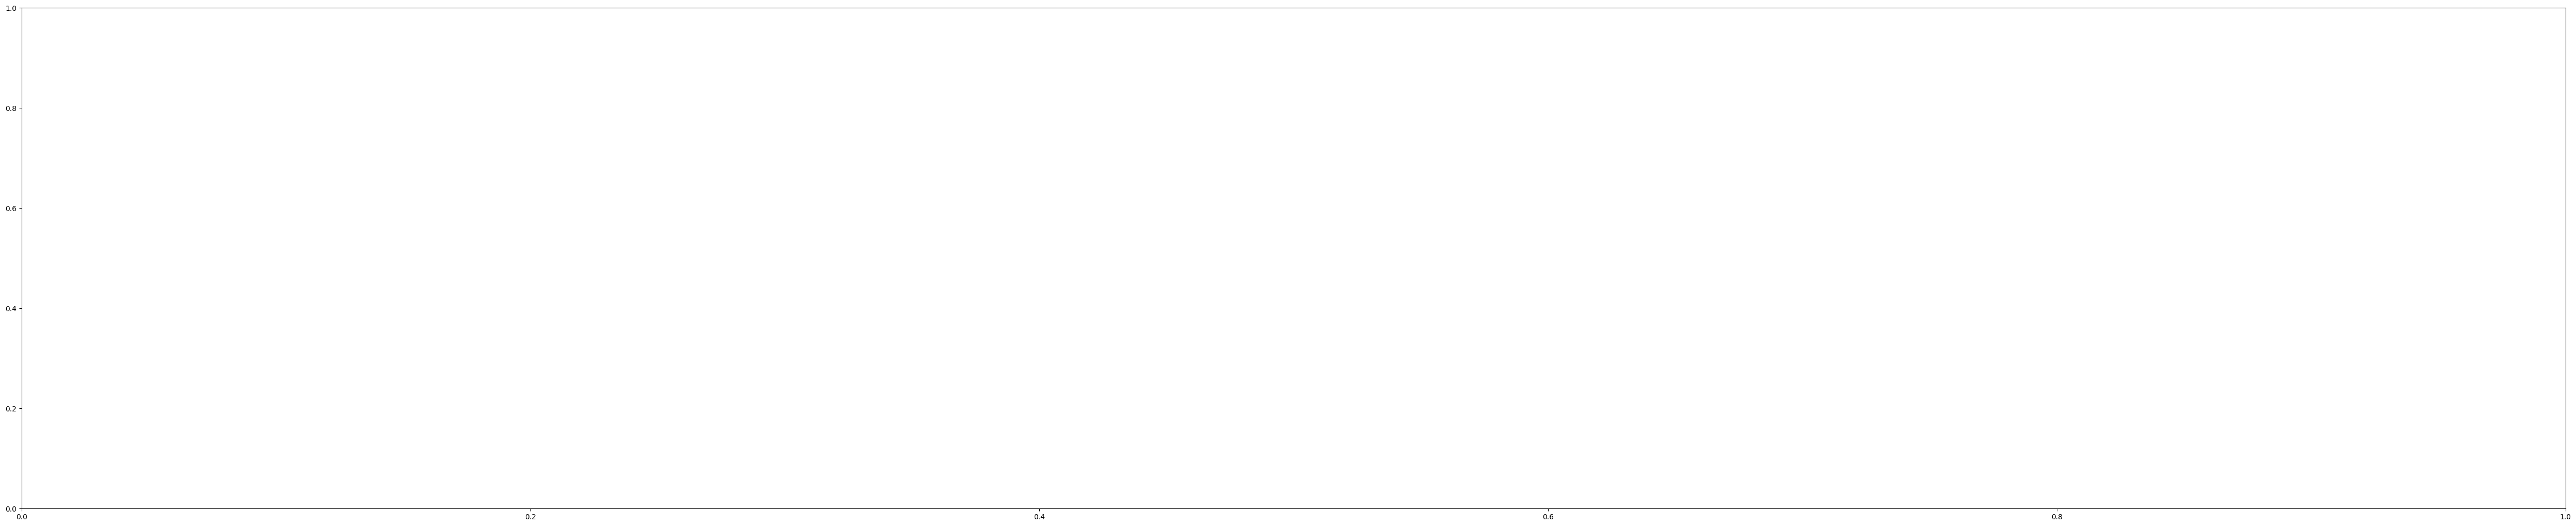

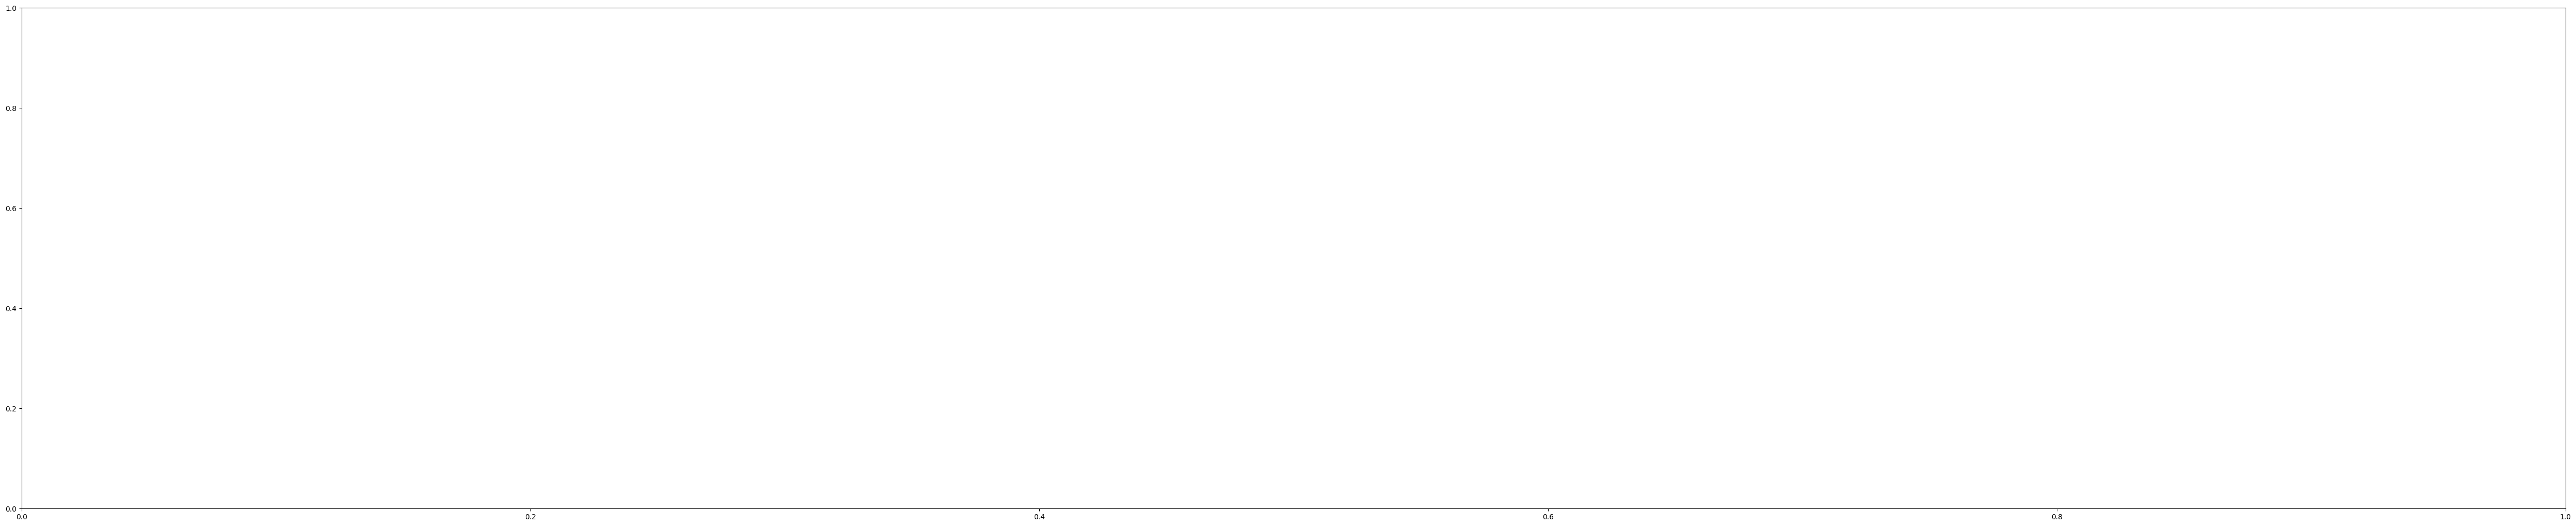

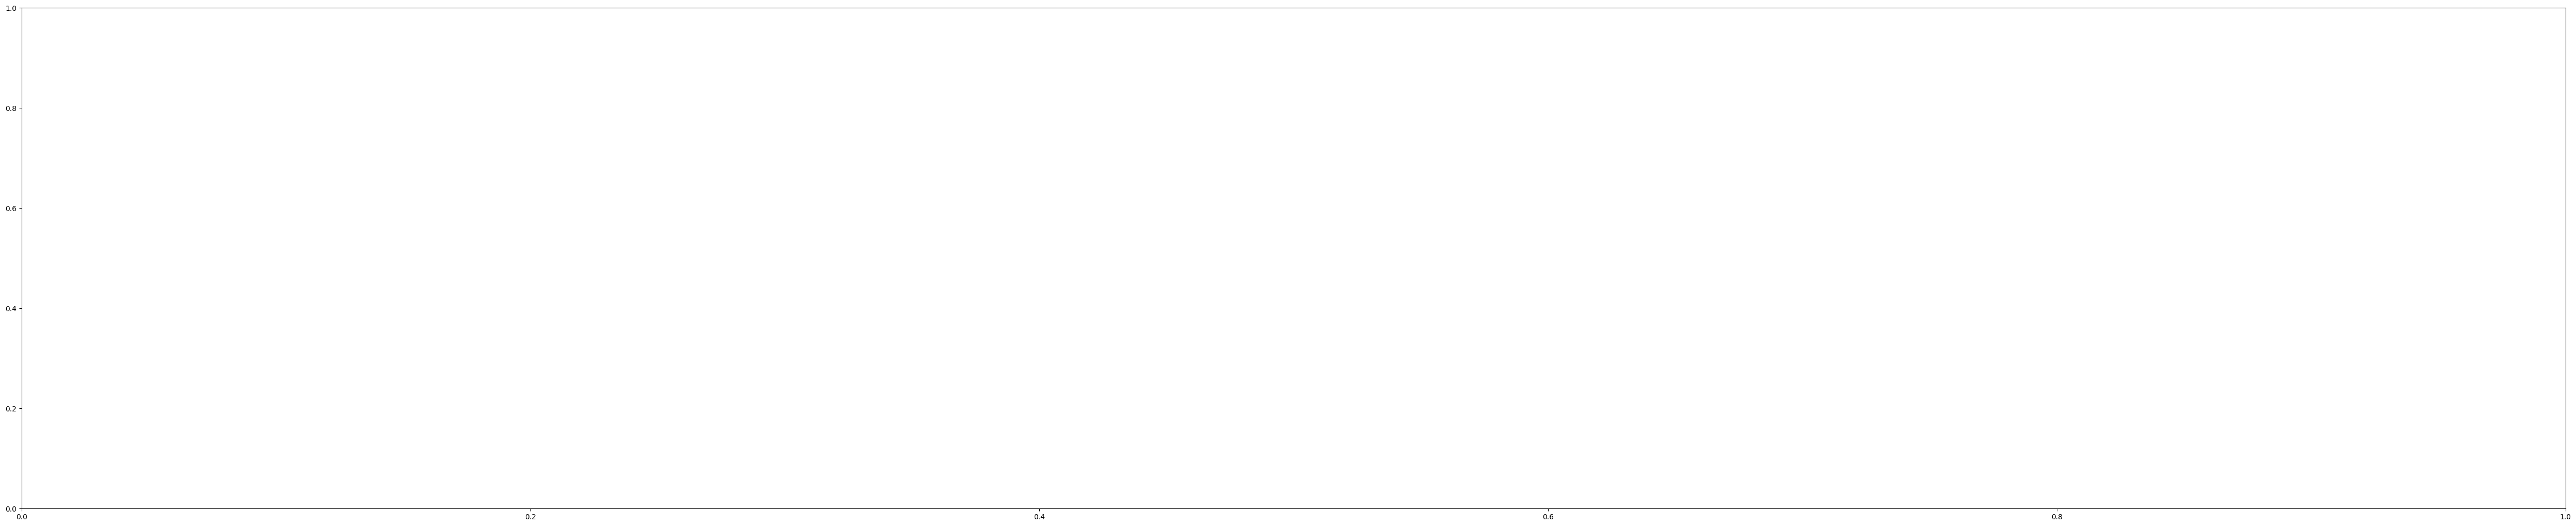

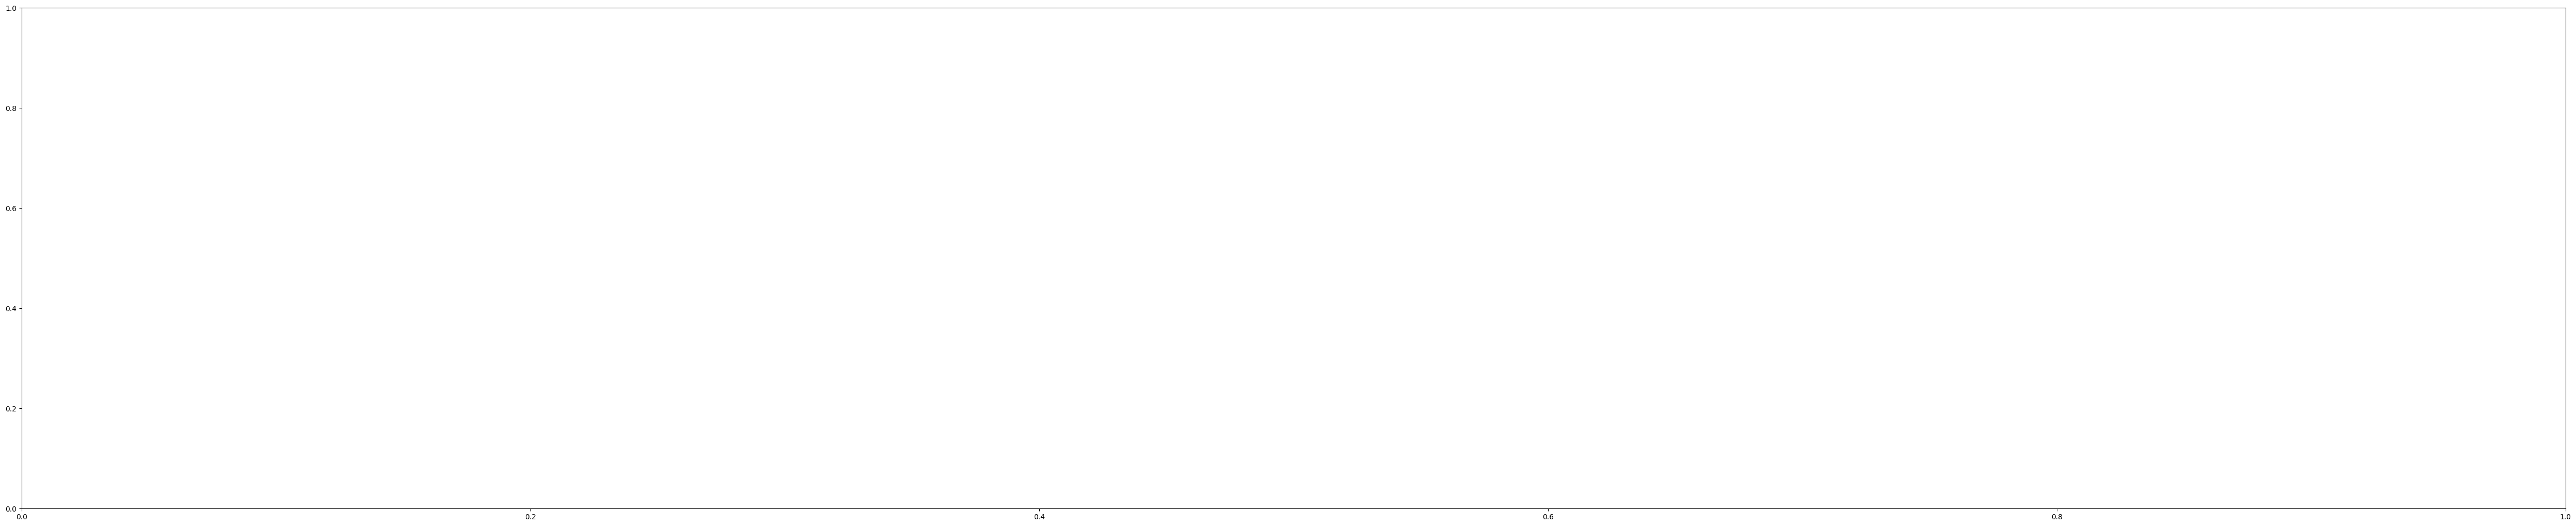

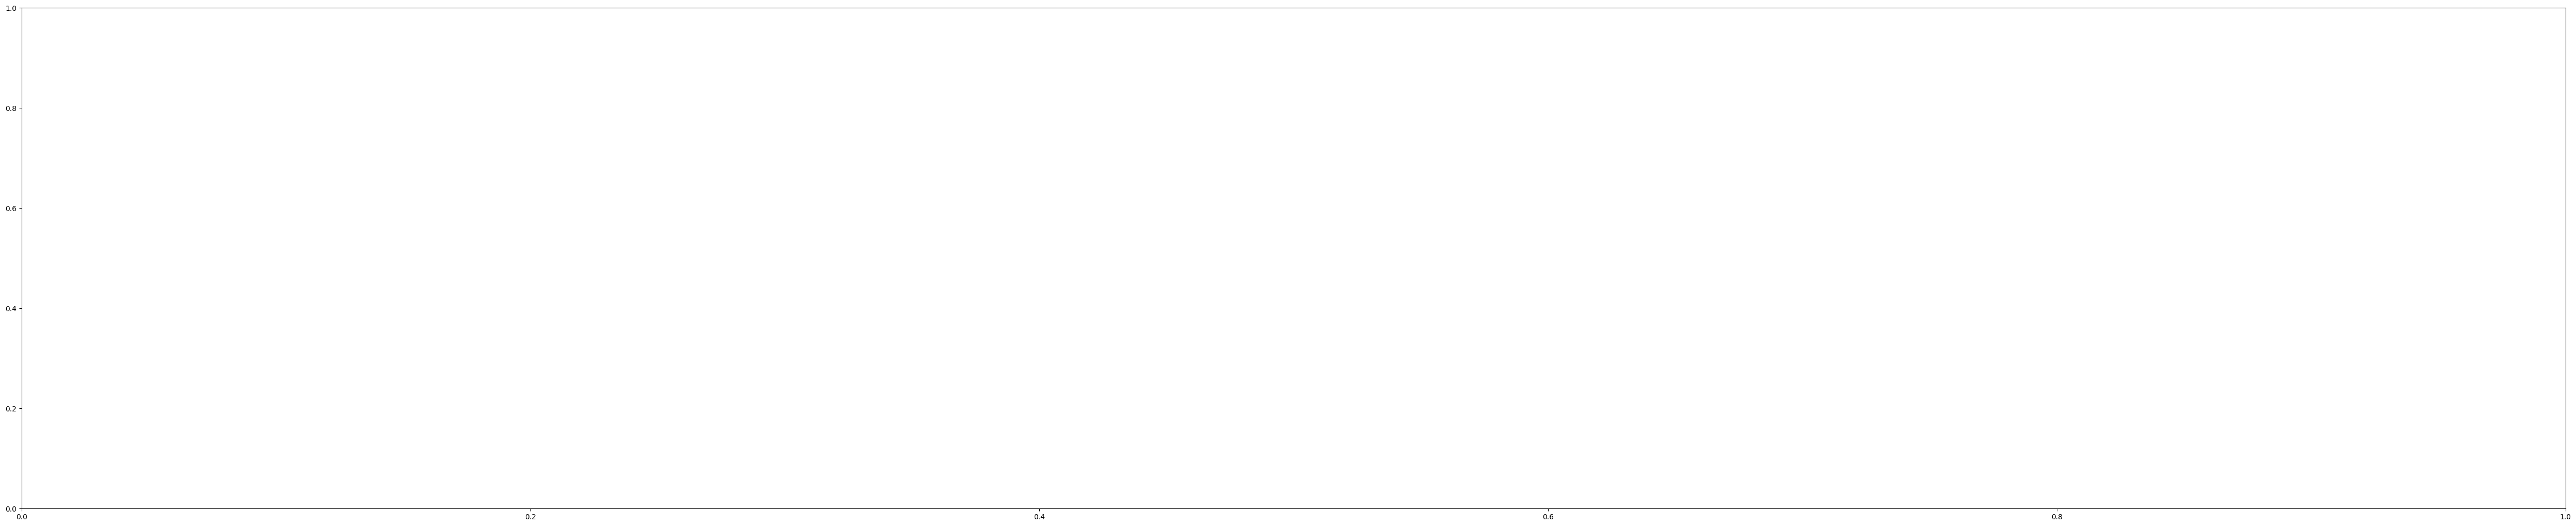

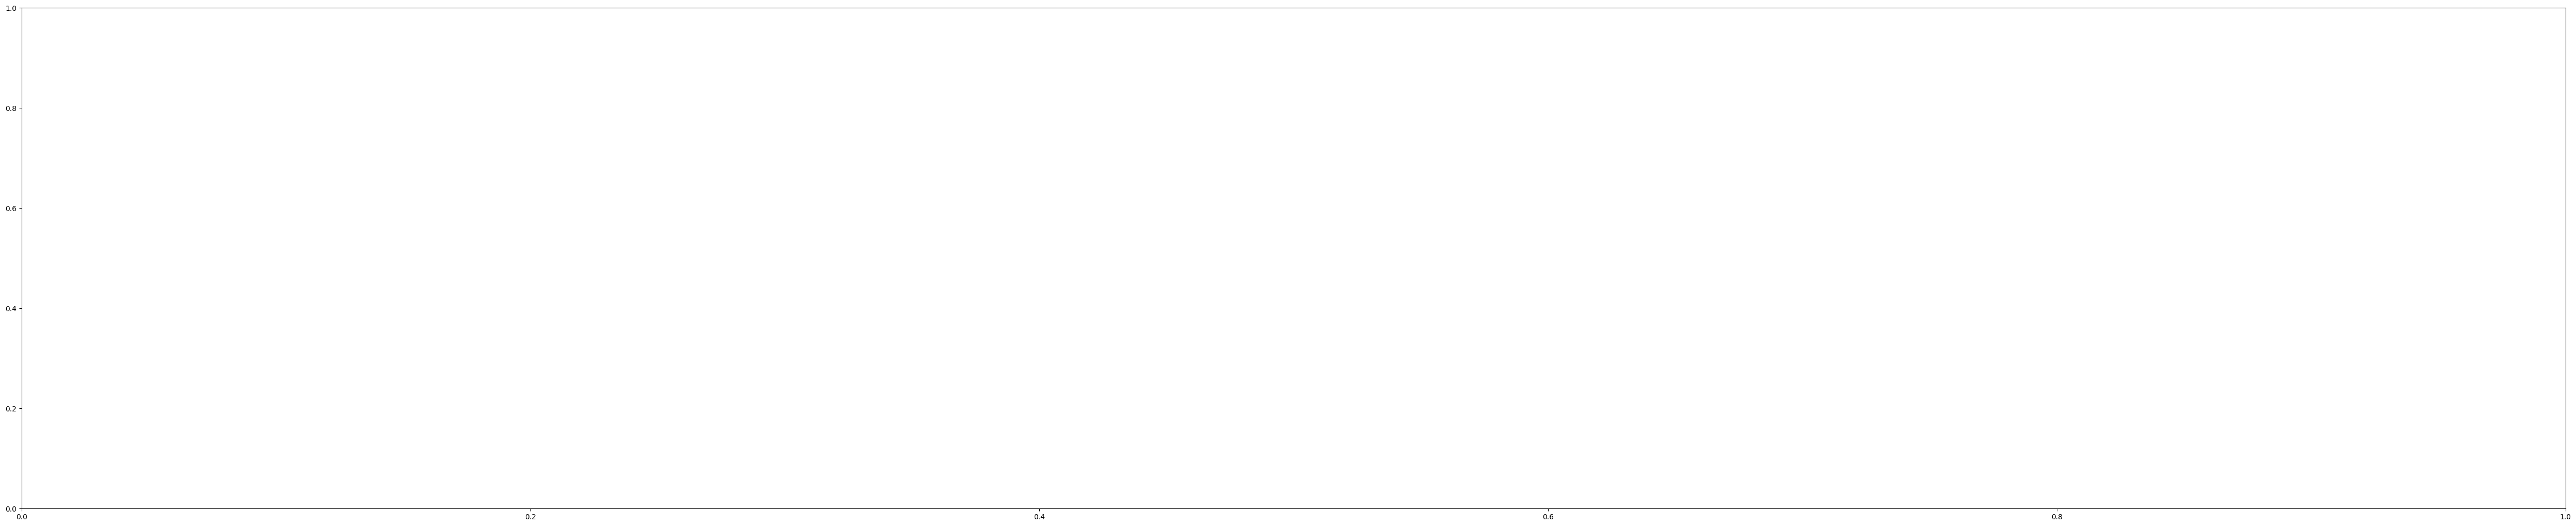

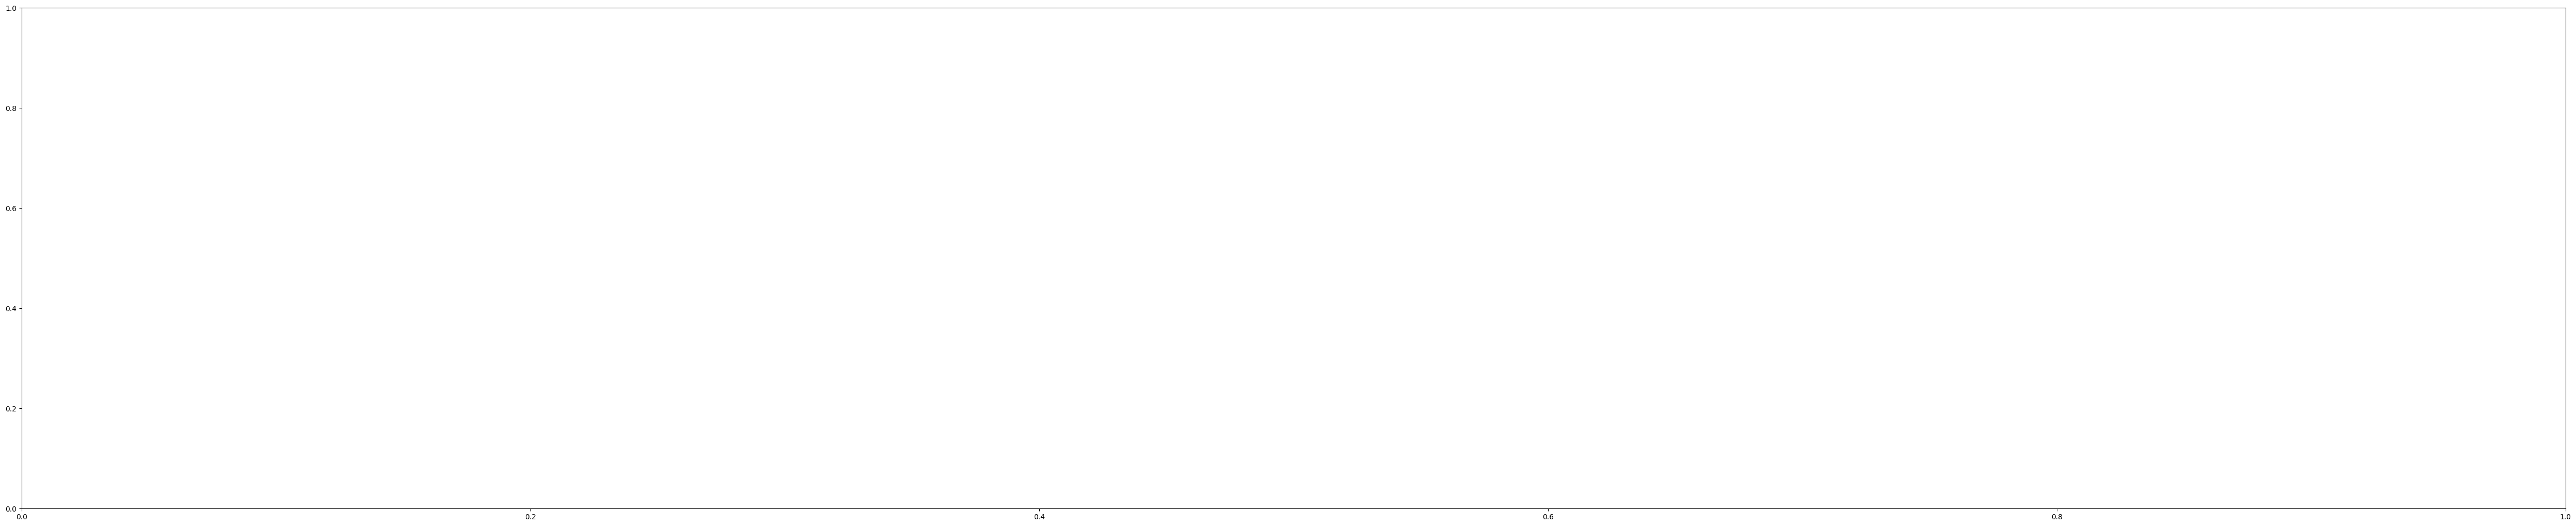

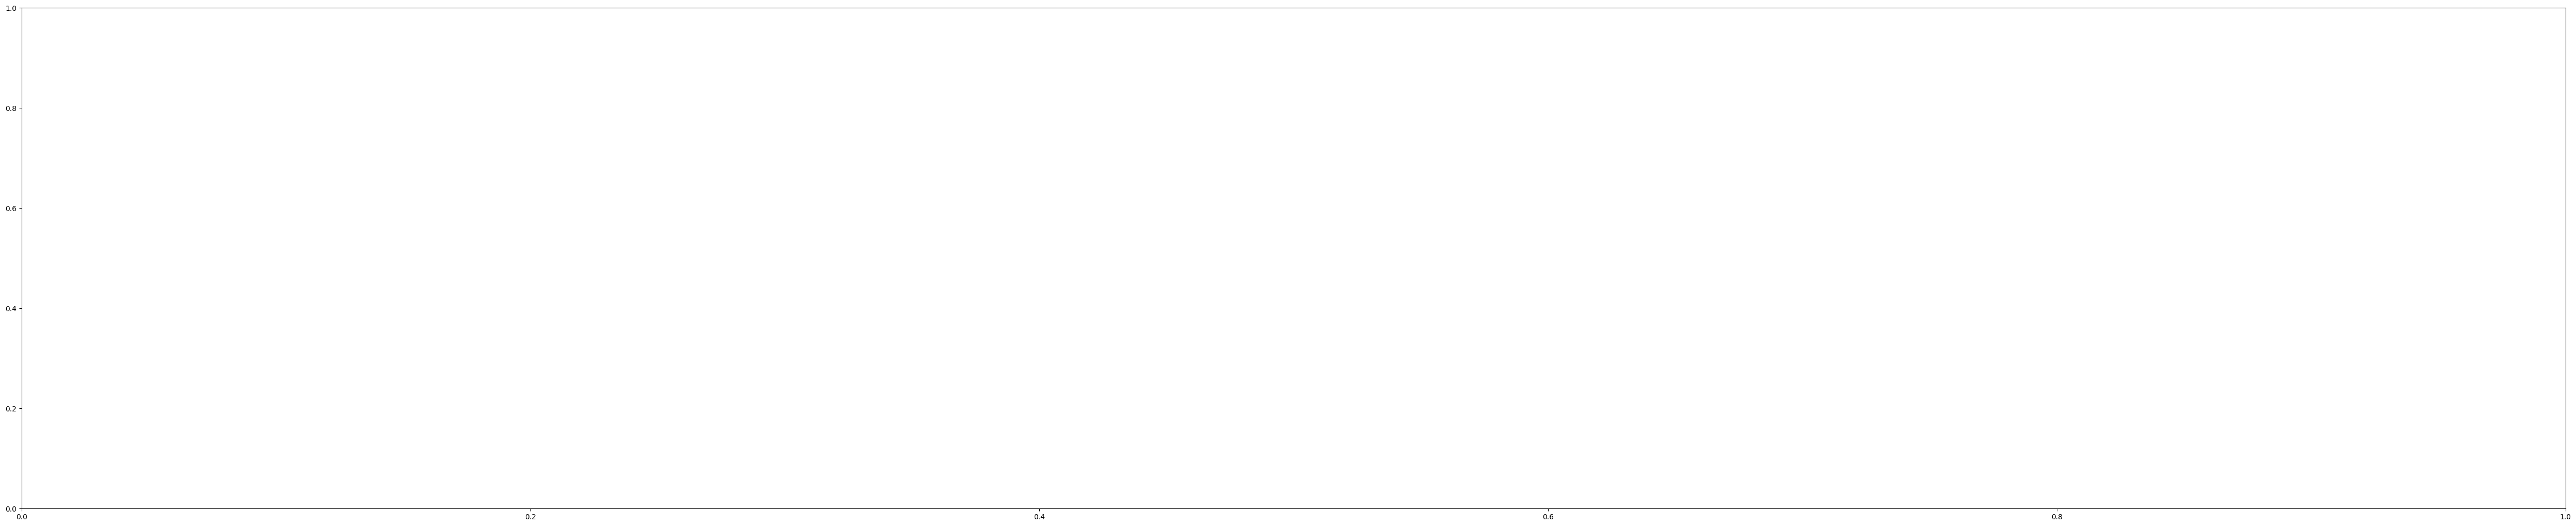

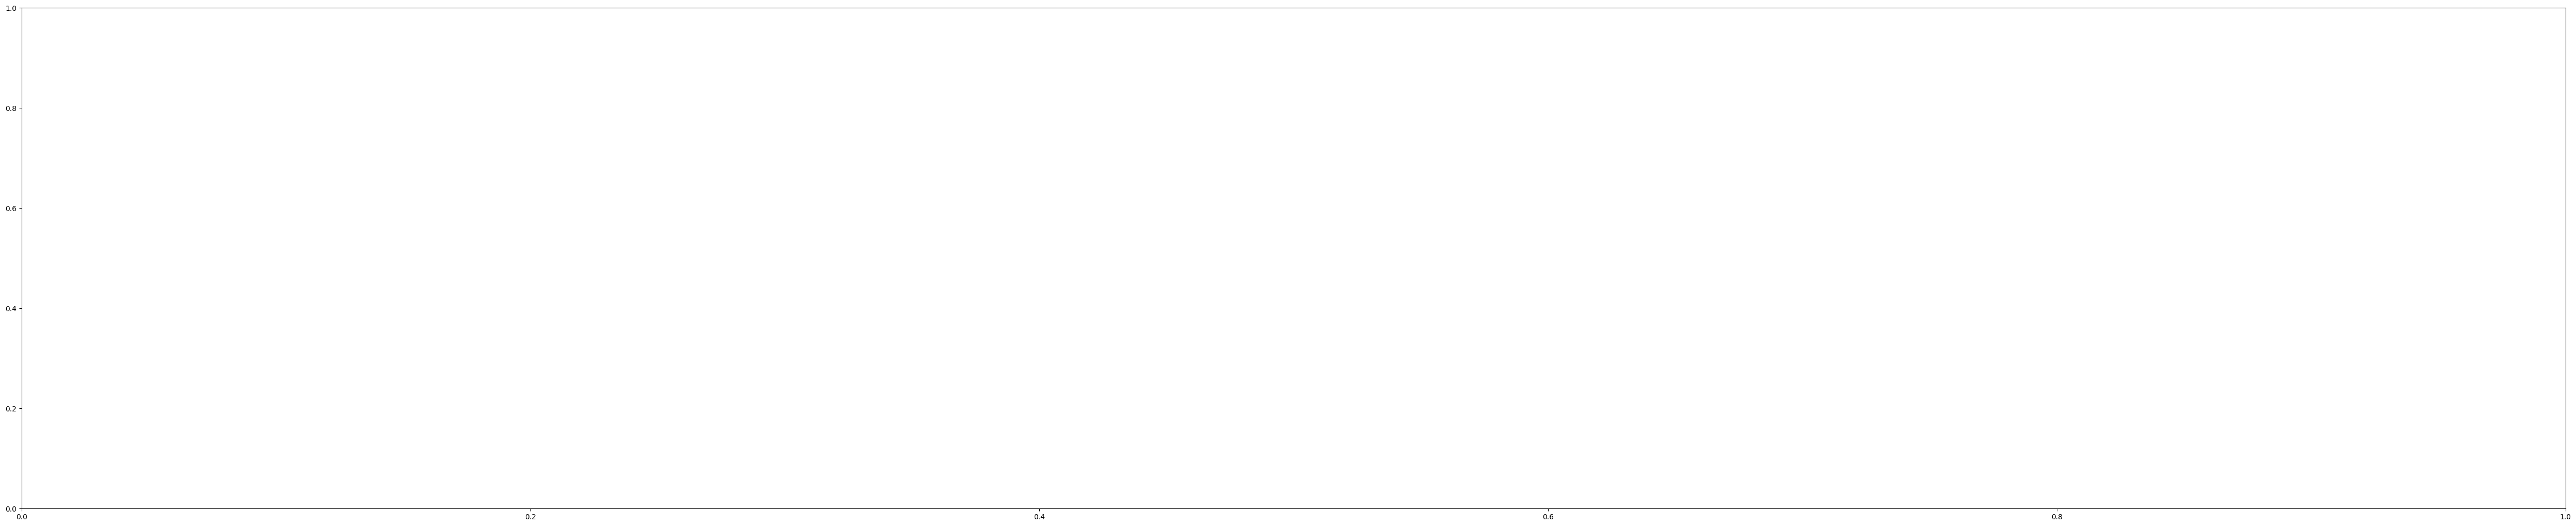

In [50]:
# print les BB 
import os 
# Pour randomforest
df_randomf = new_df
df_randomf['predicted_label'] = predictions_label_randomf

#code_uniques = df_truth["code_unique"].unique()
save_path = "../../../DataSet/ResultsRand"

code_path = "../../../DataSet/ResultScikitMaad"
code_uniques = []
for file in os.listdir(code_path): 
    code = file.replace("_sckikit.png", "")
    code_uniques.append(code)

for code_unique in tqdm(code_uniques):
    image_to_compare(code_unique, save_path, df_randomf)

In [1]:
# Pour XGBoost
df_xgb = new_df
df_xgb['predicted_label'] = predictions_label_xgb

code_uniques = df_truth["code_unique"].unique()
save_path = "../../../DataSet/ResultsXGB"

for code_unique in tqdm(code_uniques):
    image_to_compare(code_unique, save_path, df_xgb)

NameError: name 'new_df' is not defined